### ResNet-LSTM
- Augment dataset using Flickr images (use only still images from the EmotiW video clips)
- ResNet-50 (standard)
- LSTM

Best Model:
- epoch 6: loss: 1.0660 - accuracy: 0.4564 - val_loss: 1.0929 - val_accuracy: 0.4402

Notes:
- May have too many parameters


In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .

In [0]:
!tar -xzf train_frames.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
!tar -xzf val_frames.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/flickr.tar.gz' .
!tar -xzf flickr.tar.gz

In [0]:
!ls

drive	flickr.tar.gz  train_frames	    val_frames
flickr	sample_data    train_frames.tar.gz  val_frames.tar.gz


In [0]:
!nvidia-smi

Sat May 23 08:30:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames
    """
    def __init__(self, dir, flickr_dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.flickr_dir = flickr_dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = []
        vid_to_cat = {}
        completed_videos = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                if frame_arr[0] not in completed_videos:
                    vid_name = join(cat_path, frame)
                    vid_to_cat[vid_name] = category_folder
                    video_map.append(vid_name)
                    completed_videos[frame_arr[0]] = True

        if self.flickr_dir is not None:
            # Inject the Flickr photos
            category_folders = [f for f in listdir(self.flickr_dir) if not isfile(join(self.flickr_dir, f))]
            for category_folder in category_folders:
                cat_path = join(self.flickr_dir, category_folder)
                photos = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
                for photo in photos:
                    photo = join(cat_path, photo)
                    if category_folder == "positive":
                        vid_to_cat[photo] = "1"
                    if category_folder == "neutral":
                        vid_to_cat[photo] = "2"
                    if category_folder == "negative":
                        vid_to_cat[photo] = "3"
                    video_map.append(photo)

        return video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")
        X = np.zeros((len(video_names), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print("   " + frame)
            img = cv2.imread(vid)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
            X[i, :, :, :] = img

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
BATCH_SIZE = 32
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-lstm-flickr-v3"

In [0]:
train_generator = DataGenerator("train_frames", "flickr", batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", None, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)


Found 12836 frames belonging to 12836 videos belonging to 3 classes.
Min frames determined to be -1
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be -1


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


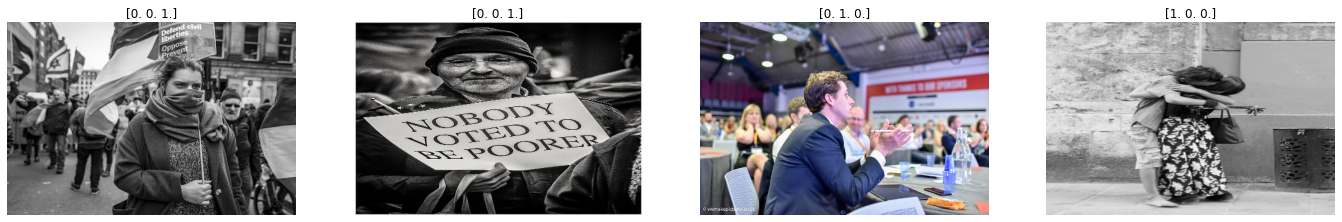

In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(4):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n])
          plt.title(label_batch[n])
          plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(1)
show_batch(image_batch, label_batch)

In [0]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    period=1)

def create_model(inputs):
    # Extract ResNet part of the model
    base_model = get_base_model()
    base_model.trainable = False
    x = base_model(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 320, 480, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 10, 15, 2048)      23587712  
_________________________________________________________________
flatten (Flatten)            (None, 307200)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               78643456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771 

In [0]:
initial_epochs = 30

# Try evaluating the model for a few rounds
loss0, accuracy0 = model.evaluate(validation_generator, steps = 3)

3/3 [==============================] - 0s 128ms/step - loss: 1.6773 - accuracy: 0.2917


In [0]:
validation_generator.batch_size

32

In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=initial_epochs,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

Epoch 1/30
401/401 [==============================] - ETA: 0s - loss: 4.2207 - accuracy: 0.4236
Epoch 00001: saving model to drive/My Drive/checkpoints/resnet-lstm-flickr-v3/cp-0001.ckpt
401/401 [==============================] - 164s 409ms/step - loss: 4.2207 - accuracy: 0.4236 - val_loss: 1.1467 - val_accuracy: 0.4144
Epoch 2/30
401/401 [==============================] - ETA: 0s - loss: 1.2007 - accuracy: 0.4657
Epoch 00002: saving model to drive/My Drive/checkpoints/resnet-lstm-flickr-v3/cp-0002.ckpt
401/401 [==============================] - 164s 409ms/step - loss: 1.2007 - accuracy: 0.4657 - val_loss: 1.1901 - val_accuracy: 0.3818
Epoch 3/30
401/401 [==============================] - ETA: 0s - loss: 1.1985 - accuracy: 0.4717
Epoch 00003: saving model to drive/My Drive/checkpoints/resnet-lstm-flickr-v3/cp-0003.ckpt
401/401 [==============================] - 155s 386ms/step - loss: 1.1985 - accuracy: 0.4717 - val_loss: 1.1442 - val_accuracy: 0.4185
Epoch 4/30
401/401 [==============

KeyboardInterrupt: ignored

In [0]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    period=1)

def create_model(inputs):
    # Extract ResNet part of the model
    base_model = get_base_model()
    base_model.trainable = False
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 320, 480, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 10, 15, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 771       
Total params: 24,113,027
Trainable params: 525,315
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=initial_epochs,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history-v2.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

Epoch 1/30
401/401 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.6001
Epoch 00001: saving model to drive/My Drive/checkpoints/resnet-lstm-flickr-v3/cp-0001.ckpt
401/401 [==============================] - 159s 396ms/step - loss: 0.8585 - accuracy: 0.6001 - val_loss: 1.0852 - val_accuracy: 0.4579
Epoch 2/30
401/401 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.6714
Epoch 00002: saving model to drive/My Drive/checkpoints/resnet-lstm-flickr-v3/cp-0002.ckpt
401/401 [==============================] - 147s 366ms/step - loss: 0.7274 - accuracy: 0.6714 - val_loss: 1.0216 - val_accuracy: 0.5054
Epoch 3/30
401/401 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7050
Epoch 00003: saving model to drive/My Drive/checkpoints/resnet-lstm-flickr-v3/cp-0003.ckpt
401/401 [==============================] - 145s 362ms/step - loss: 0.6670 - accuracy: 0.7050 - val_loss: 1.0709 - val_accuracy: 0.5041
Epoch 4/30
401/401 [==============

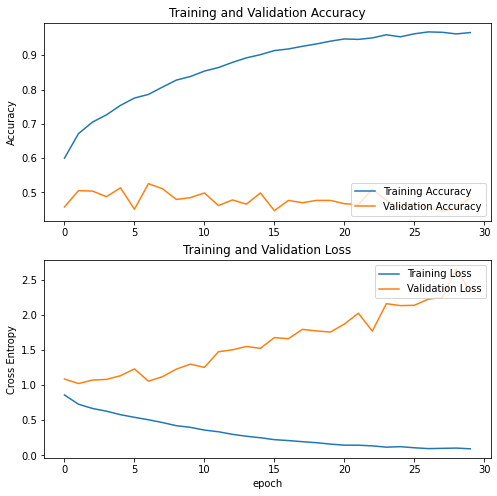

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/m1.h5")
